<a href="https://colab.research.google.com/github/KjellbergWille/Labs_Advanced_ML/blob/main/D7047E_LAB2_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practical Tasks 2
This lab focuses on helping you better understand the different methods used
for generating images. You can use the codes in the links provided, but you are
expected to understand them and may be asked to explain what certain parts
of the code do.

NOTE: This is an extension of an old lab so be aware of the TensorFlow
code; we suggest you use it as a guide, not develop your code in TensorFlow.


# Task 2.1
Implement a Vanilla GAN as described by Goodfellow in his paper: https://arxiv.org/abs/1406.2661 to generate adversarial MNIST images. Here is
a link to a Tensorflow implementation where they explain the code and its steps
https://wiseodd.github.io/techblog/2016/09/17/gan-tensorflow/. The
paper links to a github which has a Pytorch version you can use as a guide for
building your vanilla GAN. Run the code with the original loss described by
Goodfellow and observe the results.

In [1]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable
from torchvision.datasets import MNIST
from torchvision import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mb_size = 64

# Load MNIST dataset using PyTorch
mnist = MNIST('../../MNIST_data', train=True, download=True, transform=transforms.ToTensor())
data_loader = torch.utils.data.DataLoader(mnist, batch_size=mb_size, shuffle=True)

# Update X_dim
X_dim = 28 * 28  # Since MNIST images are 28x28

Z_dim = 100
y_dim = 10  # Number of classes in MNIST dataset
h_dim = 128
c = 0
lr = 1e-3

def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / np.sqrt(in_dim / 2.)
    return Variable(torch.randn(*size) * xavier_stddev, requires_grad=True)

""" ==================== GENERATOR ======================== """
Wzh = xavier_init(size=[Z_dim, h_dim])
bzh = Variable(torch.zeros(h_dim), requires_grad=True)

Whx = xavier_init(size=[h_dim, X_dim])
bhx = Variable(torch.zeros(X_dim), requires_grad=True)

def G(z):
    h = F.relu(z @ Wzh + bzh.repeat(z.size(0), 1))
    X = F.sigmoid(h @ Whx + bhx.repeat(h.size(0), 1))
    return X

""" ==================== DISCRIMINATOR ======================== """
Wxh = xavier_init(size=[X_dim, h_dim])
bxh = Variable(torch.zeros(h_dim), requires_grad=True)

Why = xavier_init(size=[h_dim, 1])
bhy = Variable(torch.zeros(1), requires_grad=True)

def D(X):
    h = F.relu(X @ Wxh + bxh.repeat(X.size(0), 1))
    y = F.sigmoid(h @ Why + bhy.repeat(h.size(0), 1))
    return y

G_params = [Wzh, bzh, Whx, bhx]
D_params = [Wxh, bxh, Why, bhy]
params = G_params + D_params

""" ===================== TRAINING ======================== """

def reset_grad():
    for p in params:
        if p.grad is not None:
            p.grad.data.zero_()

G_solver = optim.Adam(G_params, lr=1e-3)
D_solver = optim.Adam(D_params, lr=1e-3)

ones_label = Variable(torch.ones(mb_size, 1)).to(device)
zeros_label = Variable(torch.zeros(mb_size, 1)).to(device)
max_iters = 20  # Define the maximum number of iterations
prev_average_loss = np.inf
patience = 0

for epoch in range(max_iters):
    inter = 0
    for X, _ in data_loader:

        X = X.view(-1, X_dim).to(device)

        # Train discriminator
        z = Variable(torch.randn(mb_size, Z_dim)).to(device)
        G_sample = G(z)
        D_real = D(X)
        D_fake = D(G_sample)

        ones_label = torch.ones(D_real.size()).to(device)
        zeros_label = torch.zeros(D_fake.size()).to(device)

        D_loss_real = F.binary_cross_entropy(D_real, ones_label)
        D_loss_fake = F.binary_cross_entropy(D_fake, zeros_label)
        D_loss = D_loss_real + D_loss_fake

        D_solver.zero_grad()  # Reset gradients for discriminator optimizer
        D_loss.backward()
        D_solver.step()

        # Train generator
        z = Variable(torch.randn(mb_size, Z_dim)).to(device)
        G_sample = G(z)
        D_fake = D(G_sample)
        ones_label_G = torch.ones(D_fake.size()).to(device)
        G_loss = F.binary_cross_entropy(D_fake, ones_label_G)

        G_solver.zero_grad()  # Reset gradients for generator optimizer
        G_loss.backward()
        G_solver.step()



        if inter % 100 == 0:
            average_loss = (D_loss+G_loss)/2
            if average_loss < prev_average_loss:
              prev_average_loss = average_loss
              patience = 0
            else:
              #print("\n patience:",patience,"average loss:",average_loss)
              patience +=1
            if patience >2:
              pass
            print('Epoch-{}; Iteration-{} D_loss: {:.4}; G_loss: {:.4}'.format(epoch,inter, D_loss.item(), G_loss.item()))

            samples = G(z).cpu().data.numpy()[:16]

            fig = plt.figure(figsize=(4, 4))
            gs = gridspec.GridSpec(4, 4)
            gs.update(wspace=0.05, hspace=0.05)

            for i, sample in enumerate(samples):
                ax = plt.subplot(gs[i])
                plt.axis('off')
                ax.set_xticklabels([])
                ax.set_yticklabels([])
                ax.set_aspect('equal')
                plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

            if not os.path.exists('out/'):
                os.makedirs('out/')

            plt.savefig('out/{}.png'.format(str(c).zfill(3)), bbox_inches='tight')
            c += 1
            plt.close(fig)
        inter +=1

    if epoch >= max_iters:
        break  # Terminate the loop after reaching max_iters


Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 9912422/9912422 [00:00<00:00, 15246388.14it/s]


Extracting ../../MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to ../../MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 28881/28881 [00:00<00:00, 512611.32it/s]


Extracting ../../MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to ../../MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 1648877/1648877 [00:00<00:00, 4372231.84it/s]


Extracting ../../MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 4542/4542 [00:00<00:00, 568163.70it/s]


Extracting ../../MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../MNIST_data/MNIST/raw

Epoch-0; Iteration-0 D_loss: 1.565; G_loss: 2.244
Epoch-0; Iteration-100 D_loss: 0.4531; G_loss: 3.474
Epoch-0; Iteration-200 D_loss: 0.05769; G_loss: 5.455
Epoch-0; Iteration-300 D_loss: 0.01058; G_loss: 6.001
Epoch-0; Iteration-400 D_loss: 0.04089; G_loss: 5.939
Epoch-0; Iteration-500 D_loss: 0.0192; G_loss: 6.554
Epoch-0; Iteration-600 D_loss: 0.00634; G_loss: 6.583
Epoch-0; Iteration-700 D_loss: 0.01085; G_loss: 7.39
Epoch-0; Iteration-800 D_loss: 0.007182; G_loss: 8.862
Epoch-0; Iteration-900 D_loss: 0.005753; G_loss: 10.64
Epoch-1; Iteration-0 D_loss: 0.01038; G_loss: 9.089
Epoch-1; Iteration-100 D_loss: 0.003666; G_loss: 8.478
Epoch-1; Iteration-200 D_loss: 0.01064; G_loss: 8.442
Epoch-1; Iteration-300 D_loss: 0.004644; G_loss: 6.54
Epoch-1; Iteration-400 D_loss: 0.004803; G_loss: 7.131
Epoch-1; Iteration-500 D_loss: 0.005891; G_loss: 7.53
Epoch-1; Iteration-600 D_loss: 0.003911; G_los

## Comments for task 2.1

#Task 2.2
Run the same code with a different loss function: Logistic loss as described in
Brandon Amos blog http://bamos.github.io/2016/08/09/deep-completion/
and compare the results with above task 1.1. Run the code for 20k iterations
and then for 100k iterations and observe the results in both cases. How/why is
the output different for both cases? Try to find a suitable reason for both.

In [3]:
# CODE FOR 2.2 HERE

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mb_size = 64

# Load MNIST dataset using PyTorch
mnist = MNIST('../../MNIST_data', train=True, download=True, transform=transforms.ToTensor())
data_loader = torch.utils.data.DataLoader(mnist, batch_size=mb_size, shuffle=True)

# Update X_dim
X_dim = 28 * 28  # Since MNIST images are 28x28

Z_dim = 100
y_dim = 10  # Number of classes in MNIST dataset
h_dim = 128
c = 0
lr = 1e-3

def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / np.sqrt(in_dim / 2.)
    return Variable(torch.randn(*size) * xavier_stddev, requires_grad=True)

""" ==================== GENERATOR ======================== """
Wzh = xavier_init(size=[Z_dim, h_dim])
bzh = Variable(torch.zeros(h_dim), requires_grad=True)

Whx = xavier_init(size=[h_dim, X_dim])
bhx = Variable(torch.zeros(X_dim), requires_grad=True)

def G(z):
    h = F.relu(z @ Wzh + bzh.repeat(z.size(0), 1))
    X = F.sigmoid(h @ Whx + bhx.repeat(h.size(0), 1))
    return X

""" ==================== DISCRIMINATOR ======================== """
Wxh = xavier_init(size=[X_dim, h_dim])
bxh = Variable(torch.zeros(h_dim), requires_grad=True)

Why = xavier_init(size=[h_dim, 1])
bhy = Variable(torch.zeros(1), requires_grad=True)

def D(X):
    h = F.relu(X @ Wxh + bxh.repeat(X.size(0), 1))
    y = F.sigmoid(h @ Why + bhy.repeat(h.size(0), 1))
    return y

G_params = [Wzh, bzh, Whx, bhx]
D_params = [Wxh, bxh, Why, bhy]
params = G_params + D_params

""" ===================== TRAINING ======================== """

def reset_grad():
    for p in params:
        if p.grad is not None:
            p.grad.data.zero_()

G_solver = optim.Adam(G_params, lr=1e-3)
D_solver = optim.Adam(D_params, lr=1e-3)

ones_label = Variable(torch.ones(mb_size, 1)).to(device)
zeros_label = Variable(torch.zeros(mb_size, 1)).to(device)
max_iters = 100  # Define the maximum number of iterations

for epoch in range(max_iters):
    inter = 0
    for X, _ in data_loader:

        X = X.view(-1, X_dim).to(device)

        # Train discriminator
        z = Variable(torch.randn(mb_size, Z_dim)).to(device)
        G_sample = G(z)
        D_real = D(X)
        D_fake = D(G_sample)

        ones_label = torch.ones(D_real.size()).to(device)
        zeros_label = torch.zeros(D_fake.size()).to(device)

        D_loss_real = F.binary_cross_entropy_with_logits(D_real, ones_label)
        D_loss_fake = F.binary_cross_entropy_with_logits(D_fake, zeros_label)
        D_loss = D_loss_real + D_loss_fake

        D_solver.zero_grad()  # Reset gradients for discriminator optimizer
        D_loss.backward()
        D_solver.step()

        # Train generator
        z = Variable(torch.randn(mb_size, Z_dim)).to(device)
        G_sample = G(z)
        D_fake = D(G_sample)
        ones_label_G = torch.ones(D_fake.size()).to(device)
        G_loss = F.binary_cross_entropy_with_logits(D_fake, ones_label_G)

        G_solver.zero_grad()  # Reset gradients for generator optimizer
        G_loss.backward()
        G_solver.step()

        if inter % 100 == 0:
            print('Epoch-{}; Iteration-{} D_loss: {:.4}; G_loss: {:.4}'.format(epoch,inter, D_loss.item(), G_loss.item()))

            samples = G(z).cpu().data.numpy()[:16]

            fig = plt.figure(figsize=(4, 4))
            gs = gridspec.GridSpec(4, 4)
            gs.update(wspace=0.05, hspace=0.05)

            for i, sample in enumerate(samples):
                ax = plt.subplot(gs[i])
                plt.axis('off')
                ax.set_xticklabels([])
                ax.set_yticklabels([])
                ax.set_aspect('equal')
                plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

            if not os.path.exists('out/'):
                os.makedirs('out/')

            plt.savefig('out/{}.png'.format(str(c).zfill(3)), bbox_inches='tight')
            c += 1
            plt.close(fig)
        inter +=1

    if epoch >= max_iters:
        break  # Terminate the loop after reaching max_iters


Epoch-0; Iteration-0 D_loss: 1.535; G_loss: 0.6271
Epoch-0; Iteration-100 D_loss: 1.044; G_loss: 0.6869
Epoch-0; Iteration-200 D_loss: 1.056; G_loss: 0.69
Epoch-0; Iteration-300 D_loss: 1.083; G_loss: 0.6818
Epoch-0; Iteration-400 D_loss: 1.007; G_loss: 0.6931
Epoch-0; Iteration-500 D_loss: 1.008; G_loss: 0.6931
Epoch-0; Iteration-600 D_loss: 1.006; G_loss: 0.6931
Epoch-0; Iteration-700 D_loss: 1.006; G_loss: 0.6931
Epoch-0; Iteration-800 D_loss: 1.006; G_loss: 0.6931
Epoch-0; Iteration-900 D_loss: 1.006; G_loss: 0.6931
Epoch-1; Iteration-0 D_loss: 1.006; G_loss: 0.6931
Epoch-1; Iteration-100 D_loss: 1.006; G_loss: 0.6931
Epoch-1; Iteration-200 D_loss: 1.007; G_loss: 0.6931
Epoch-1; Iteration-300 D_loss: 1.006; G_loss: 0.6931
Epoch-1; Iteration-400 D_loss: 1.006; G_loss: 0.6931
Epoch-1; Iteration-500 D_loss: 1.006; G_loss: 0.6931
Epoch-1; Iteration-600 D_loss: 1.027; G_loss: 0.6777
Epoch-1; Iteration-700 D_loss: 1.051; G_loss: 0.6786
Epoch-1; Iteration-800 D_loss: 1.006; G_loss: 0.6931

KeyboardInterrupt: 

## Comments for task 2.2
It does not get better with more iterations. It is pretty bad

# Task 2.3
The vanilla GAN only generates images of random numbers between 0-9 but
has no labels associated with the generated images. This means that if you
want it to generate MNIST-looking images of 3s, then it will not understand
and generate a random number instead. You will now add/change code in your
GAN from task 1 to create a conditional GAN (CGAN) and then plot a few
generated images of any number you choose between 0-9 to see if your GAN
knows the classes.

HINT: The Discriminator and Generator now have two inputs instead of one.


In [4]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable
from torchvision.datasets import MNIST
from torchvision import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mb_size = 64

# Load MNIST dataset using PyTorch
mnist = MNIST('../../MNIST_data', train=True, download=True, transform=transforms.ToTensor())
data_loader = torch.utils.data.DataLoader(mnist, batch_size=mb_size, shuffle=True)

# Update X_dim
X_dim = 28 * 28  # Since MNIST images are 28x28

Z_dim = 110 #added 10 dimensions for the digit labels
y_dim = 10  # Number of classes in MNIST dataset
h_dim = 128
c = 0
lr = 1e-3

def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / np.sqrt(in_dim / 2.)
    return Variable(torch.randn(*size) * xavier_stddev, requires_grad=True)

""" ==================== GENERATOR ======================== """
Wzh = xavier_init(size=[Z_dim + y_dim, h_dim])
bzh = Variable(torch.zeros(h_dim), requires_grad=True)

Whx = xavier_init(size=[h_dim, X_dim])
bhx = Variable(torch.zeros(X_dim), requires_grad=True)


def G(z, y): # added 1 more input and concatenate them
    inputs = torch.cat([z, y], dim=1)
    h = F.relu(inputs @ Wzh + bzh.repeat(inputs.size(0), 1))
    X = F.sigmoid(h @ Whx + bhx.repeat(h.size(0), 1))
    return X
""" ==================== DISCRIMINATOR ======================== """
Wxh = xavier_init(size=[X_dim+10, h_dim])
bxh = Variable(torch.zeros(h_dim), requires_grad=True)

Why = xavier_init(size=[h_dim, 1])
bhy = Variable(torch.zeros(1), requires_grad=True)

def D(X, y): # added 1 more input and concatenate them
    inputs = torch.cat([X, y], dim=1)
    h = F.relu(inputs @ Wxh + bxh.repeat(inputs.size(0), 1))
    y = F.sigmoid(h @ Why + bhy.repeat(h.size(0), 1))
    return y

G_params = [Wzh, bzh, Whx, bhx]
D_params = [Wxh, bxh, Why, bhy]
params = G_params + D_params

""" ===================== TRAINING ======================== """

def reset_grad():
    for p in params:
        if p.grad is not None:
            p.grad.data.zero_()

G_solver = optim.Adam(G_params, lr=1e-3)
D_solver = optim.Adam(D_params, lr=1e-3)

ones_label = Variable(torch.ones(mb_size, 1)).to(device)
zeros_label = Variable(torch.zeros(mb_size, 1)).to(device)
max_iters = 20  # Define the maximum number of iterations
prev_average_loss = np.inf
patience = 0

def generate_specific_digit(generator, digit_label, num_samples=16):
    z1 = Variable(torch.randn(num_samples, Z_dim)).to(device)  # Use Z_dim directly
    y1 = torch.zeros(num_samples, y_dim)
    y1[:, digit_label] = 1  # Set the specified digit label
    y1 = Variable(y1).to(device)
    generated_samples = generator(z1, y1).cpu().data.numpy()
    return generated_samples

for epoch in range(max_iters):
    inter = 0
    for X, labels in data_loader:

        # Convert labels to one-hot encoded vectors
        y_onehot = torch.zeros(labels.size(0), y_dim)
        y_onehot.scatter_(1, labels.unsqueeze(1), 1)

        lb_size = int(labels.size()[0])
        #print(lb_size)
        X = X.view(-1, X_dim).to(device)

        # Train discriminator
        z = Variable(torch.randn(lb_size, Z_dim)).to(device)
        y = Variable(torch.FloatTensor(lb_size, y_dim).uniform_(), requires_grad=False).to(device)  # Random digit labels
        #print("Size of z:", z.size())
        #print("Size of y:", y_onehot.to(device).size())
        G_sample = G(z, y_onehot.to(device))
        D_real = D(X.view(-1, X_dim), y_onehot.to(device))
        D_fake = D(G_sample, y_onehot.to(device))

        ones_label = torch.ones(D_real.size()).to(device)
        zeros_label = torch.zeros(D_fake.size()).to(device)

        D_loss_real = F.binary_cross_entropy(D_real, ones_label)
        D_loss_fake = F.binary_cross_entropy(D_fake, zeros_label)
        D_loss = D_loss_real + D_loss_fake

        D_solver.zero_grad()  # Reset gradients for discriminator optimizer
        D_loss.backward()
        D_solver.step()

        # Train generator
        z = Variable(torch.randn(lb_size, Z_dim)).to(device)
        y = Variable(torch.FloatTensor(lb_size, y_dim).uniform_(), requires_grad=False).to(device)  # Random digit labels
        G_sample = G(z, y_onehot.to(device))
        D_fake = D(G_sample, y_onehot.to(device))
        ones_label_G = torch.ones(D_fake.size()).to(device)
        G_loss = F.binary_cross_entropy(D_fake, ones_label_G)

        G_solver.zero_grad()  # Reset gradients for generator optimizer
        G_loss.backward()
        G_solver.step()



        if inter % 100 == 0:
            average_loss = (D_loss+G_loss)/2
            if average_loss < prev_average_loss:
              prev_average_loss = average_loss
              patience = 0
            else:
              #print("\n patience:",patience,"average loss:",average_loss)
              patience +=1
            if patience >2:
              pass
            print('Epoch-{}; Iteration-{} D_loss: {:.4}; G_loss: {:.4}'.format(epoch,inter, D_loss.item(), G_loss.item()))

            #samples = G(z).cpu().data.numpy()[:16]
            digit_label = 3  # Change this to the digit you want to generate
            generated_samples = generate_specific_digit(G, digit_label)

            fig = plt.figure(figsize=(4, 4))
            gs = gridspec.GridSpec(4, 4)
            gs.update(wspace=0.05, hspace=0.05)

            for i, sample in enumerate(generated_samples):
                ax = plt.subplot(gs[i])
                plt.axis('off')
                ax.set_xticklabels([])
                ax.set_yticklabels([])
                ax.set_aspect('equal')
                plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

            if not os.path.exists('out/'):
                os.makedirs('out/')

            plt.savefig('out/{}.png'.format(str(c).zfill(3)), bbox_inches='tight')
            c += 1
            plt.close(fig)
        inter +=1

    if epoch >= max_iters:
        break  # Terminate the loop after reaching max_iters


Epoch-0; Iteration-0 D_loss: 1.515; G_loss: 2.163
Epoch-0; Iteration-100 D_loss: 0.248; G_loss: 3.794
Epoch-0; Iteration-200 D_loss: 0.06409; G_loss: 5.882
Epoch-0; Iteration-300 D_loss: 0.06881; G_loss: 6.077
Epoch-0; Iteration-400 D_loss: 0.03132; G_loss: 6.168
Epoch-0; Iteration-500 D_loss: 0.01841; G_loss: 6.088
Epoch-0; Iteration-600 D_loss: 0.01; G_loss: 7.459
Epoch-0; Iteration-700 D_loss: 0.003173; G_loss: 9.209
Epoch-0; Iteration-800 D_loss: 0.01207; G_loss: 7.453
Epoch-0; Iteration-900 D_loss: 0.05638; G_loss: 7.557
Epoch-1; Iteration-0 D_loss: 0.005192; G_loss: 7.344
Epoch-1; Iteration-100 D_loss: 0.01181; G_loss: 8.074
Epoch-1; Iteration-200 D_loss: 0.01412; G_loss: 5.74
Epoch-1; Iteration-300 D_loss: 0.006153; G_loss: 7.5
Epoch-1; Iteration-400 D_loss: 0.006429; G_loss: 7.41
Epoch-1; Iteration-500 D_loss: 0.006198; G_loss: 7.975
Epoch-1; Iteration-600 D_loss: 0.0153; G_loss: 7.124
Epoch-1; Iteration-700 D_loss: 0.004548; G_loss: 9.019
Epoch-1; Iteration-800 D_loss: 0.00555

## Comments for task 2.3

#Task 2.4
First, train a CNN MNIST model and create adversarial images to classify 4s
as 9s. HINT: Take help from Jasoni Carter Github : https://github.com/jasonicarter/MNIST-adversarial-images Try to reason how these adversarial images are produced. Next, a random noise image was used to classify it asnine and observe the results. Compare the results from the first and the second
steps

In [5]:
#Import neccessary dependancies
import torch
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import os
from torch.autograd import Variable
from torchvision.datasets import MNIST
from torchvision import transforms
from mpl_toolkits.axes_grid1 import ImageGrid

# Download MNIST data and create data loader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mb_size = 64
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])
mnist = MNIST('../../MNIST_data', train=True, download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(mnist, batch_size=mb_size, shuffle=True)

# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 1024)
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

# Initialize the model, loss function, and optimizer
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Train the model
for epoch in range(5):  # Adjust the number of epochs as needed
    for i, (images, labels) in enumerate(data_loader):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, 5, i+1, len(data_loader), loss.item()))

# Test the model
correct = 0
total = 0
with torch.no_grad():
    for images, labels in data_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

Epoch [1/5], Step [100/938], Loss: 0.6403
Epoch [1/5], Step [200/938], Loss: 0.6374
Epoch [1/5], Step [300/938], Loss: 0.2576
Epoch [1/5], Step [400/938], Loss: 0.1388
Epoch [1/5], Step [500/938], Loss: 0.3923
Epoch [1/5], Step [600/938], Loss: 0.1201
Epoch [1/5], Step [700/938], Loss: 0.2742
Epoch [1/5], Step [800/938], Loss: 0.0340
Epoch [1/5], Step [900/938], Loss: 0.0816
Epoch [2/5], Step [100/938], Loss: 0.0543
Epoch [2/5], Step [200/938], Loss: 0.0636
Epoch [2/5], Step [300/938], Loss: 0.1399
Epoch [2/5], Step [400/938], Loss: 0.0906
Epoch [2/5], Step [500/938], Loss: 0.0970
Epoch [2/5], Step [600/938], Loss: 0.0383
Epoch [2/5], Step [700/938], Loss: 0.0734
Epoch [2/5], Step [800/938], Loss: 0.0283
Epoch [2/5], Step [900/938], Loss: 0.0289
Epoch [3/5], Step [100/938], Loss: 0.1007
Epoch [3/5], Step [200/938], Loss: 0.0650
Epoch [3/5], Step [300/938], Loss: 0.0395
Epoch [3/5], Step [400/938], Loss: 0.0260
Epoch [3/5], Step [500/938], Loss: 0.0522
Epoch [3/5], Step [600/938], Loss:

Index of '2' images: tensor([  5,  16,  25,  28,  76,  82, 109, 117, 120, 122])
Labels for '2' images: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])


IndexError: list index out of range

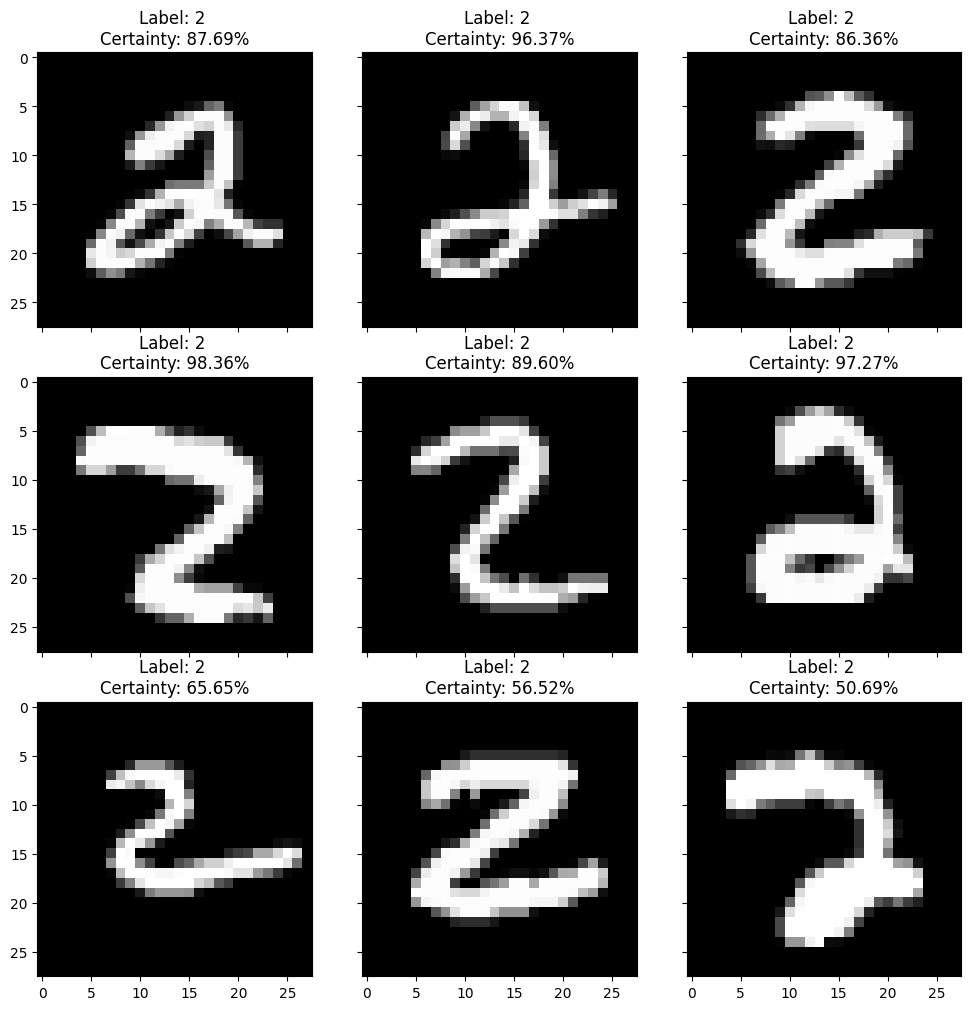

In [6]:
# Plot predictions
def plot_predictions(images, labels, output_probs=False, adversarial=False):
    prob = model(images).softmax(dim=1)
    pred_list = torch.argmax(prob, dim=1)
    pct_list = torch.max(prob, dim=1).values * 100

    fig = plt.figure(figsize=(12, 12))
    grid = ImageGrid(fig, 111, nrows_ncols=(3, 3), axes_pad=0.5)

    for i in range(len(images)):
        image = images[i].cpu().numpy().reshape(28, 28)  # Convert to NumPy array and reshape
        grid[i].imshow(image, cmap='gray')
        grid[i].set_title(f'Label: {labels[i]} \nCertainty: {pct_list[i]:.2f}%')

    plt.show()

# Get images of digit '2'
index_of_2s = torch.nonzero(mnist.targets == 2).squeeze(1)[:10]
print("Index of '2' images:", index_of_2s)

x_batch = mnist.data[index_of_2s]
print("Labels for '2' images:", mnist.targets[index_of_2s])

plot_predictions(x_batch.unsqueeze(1).float() / 255.0, mnist.targets[index_of_2s])

torch.Size([1, 1, 28, 28])
Type of obj: <class 'torch.Tensor'>


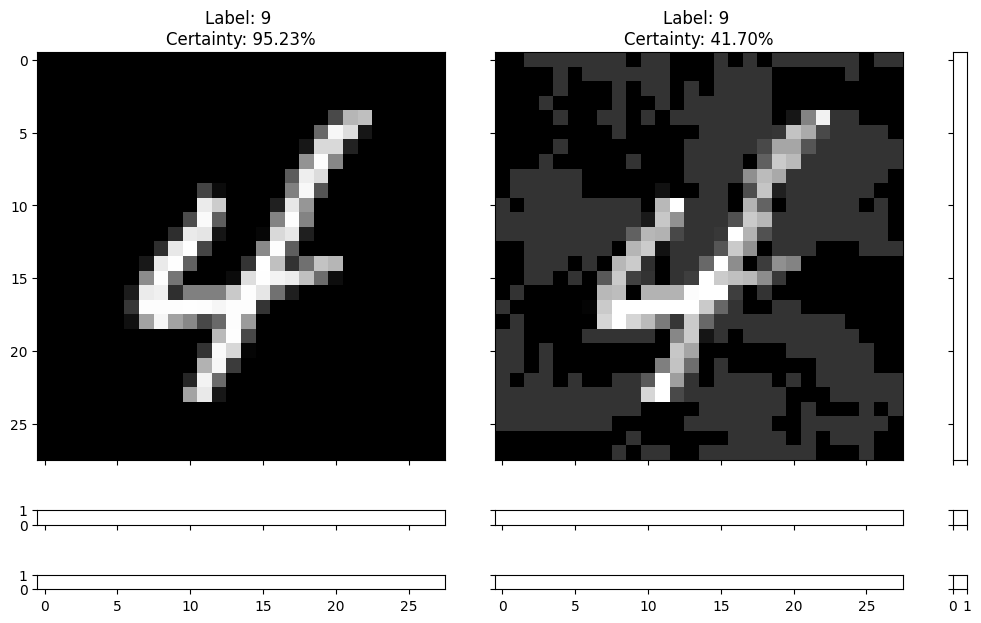

torch.Size([1, 1, 28, 28])
Type of obj: <class 'torch.Tensor'>


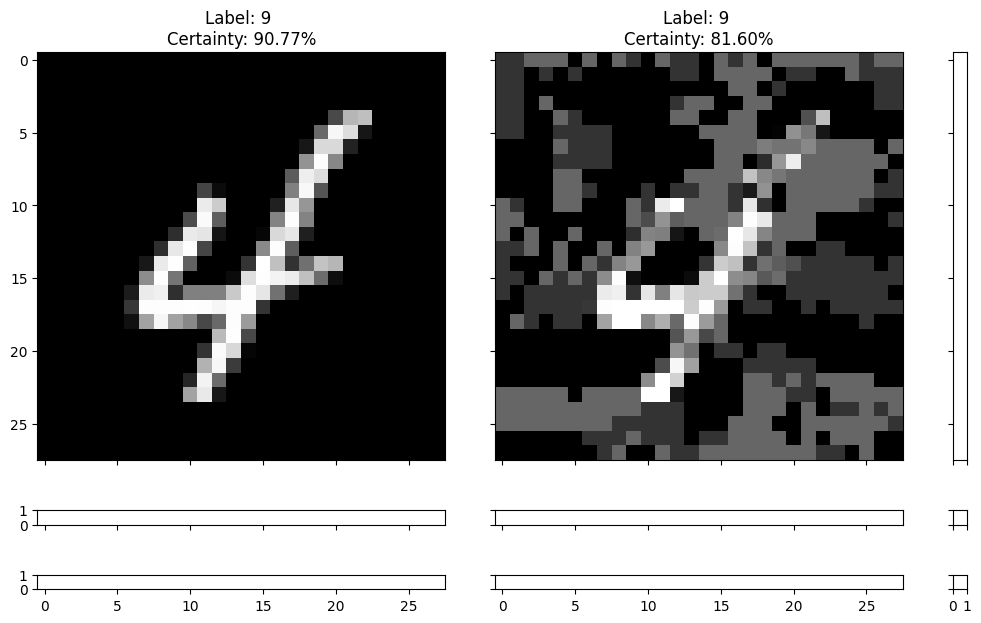

torch.Size([1, 1, 28, 28])
Type of obj: <class 'torch.Tensor'>


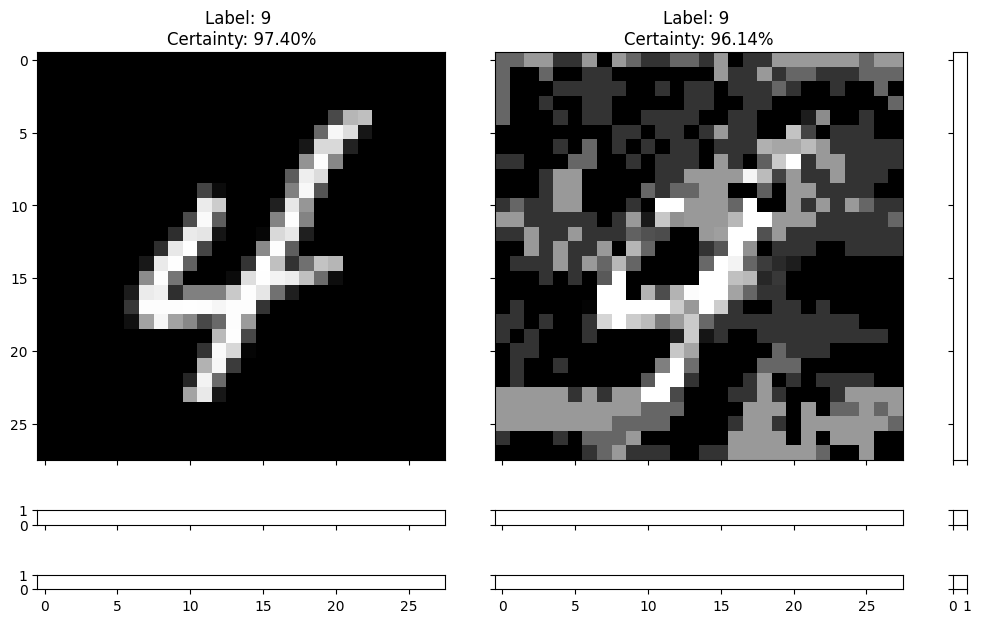

torch.Size([1, 1, 28, 28])
Type of obj: <class 'torch.Tensor'>


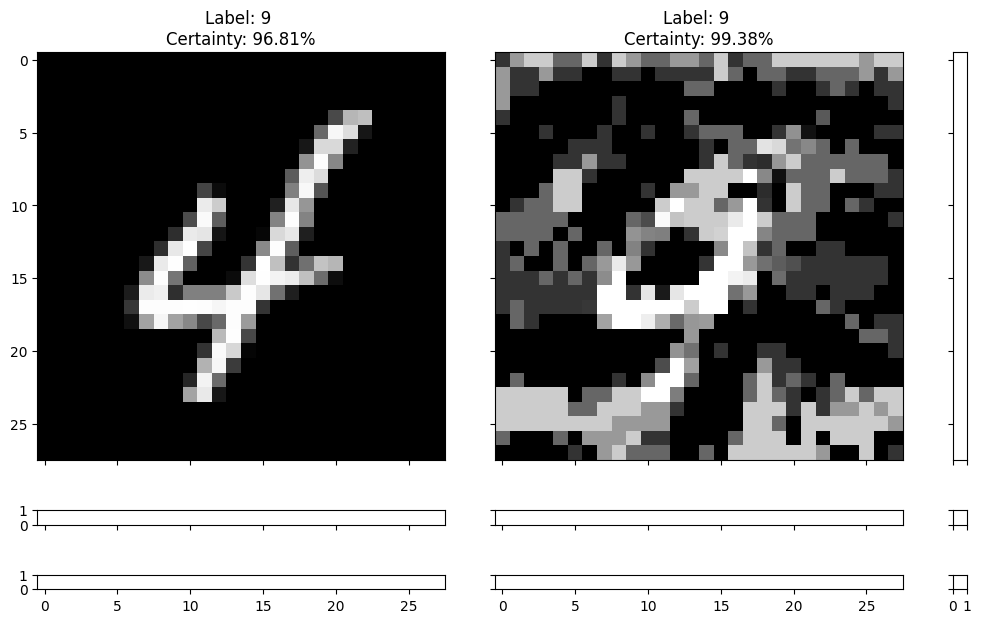

torch.Size([1, 1, 28, 28])
Type of obj: <class 'torch.Tensor'>


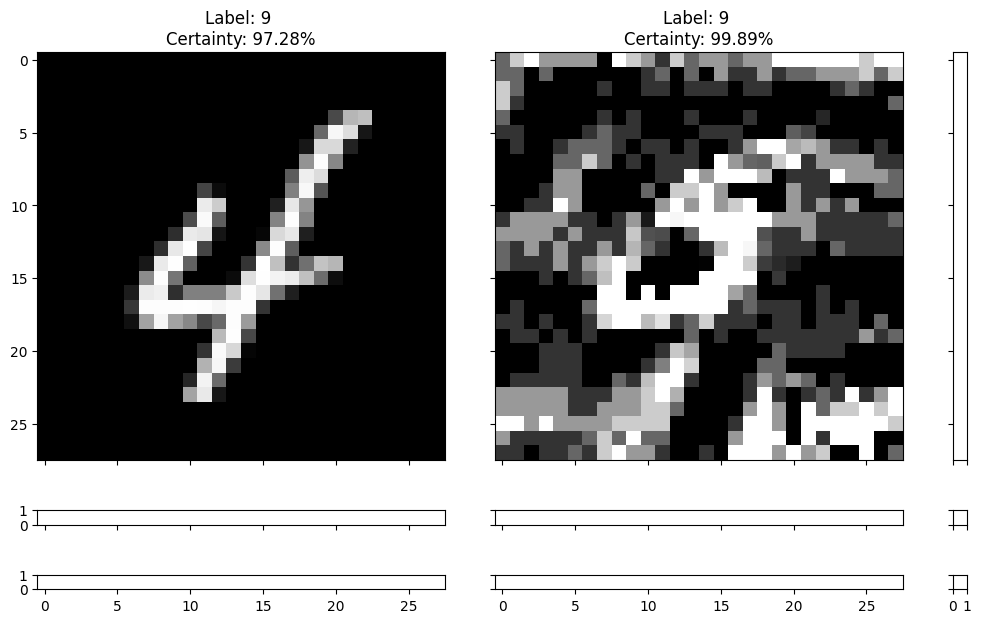

[]

In [18]:
def create_plot_adversarial_images(x_image, y_label, model, criterion, optimizer, lr=0.1, n_steps=1, output_probs=False):
    #x_image = x_image.mean(dim=1, keepdim=True)
    x_image = x_image.unsqueeze(1)
    original_image = x_image.clone().detach()
    probs_per_step = []
    x_image.requires_grad = True
    for _ in range(n_steps):
        optimizer.zero_grad()  # Zero the gradients

        # Forward pass


        x_image = x_image.detach().requires_grad_(True)
        print(x_image.shape)
        outputs = model(x_image)
        loss = criterion(outputs, y_label)

        # Backward pass
        loss.backward()  # Compute gradients

        obj_type = type(x_image.grad)

        # Print the type
        print("Type of obj:", obj_type)



        # Create adversarial image
        with torch.no_grad():

            x_adv = x_image - lr * x_image.grad.sign()
            x_adv = torch.clamp(x_adv, 0, 1)

        # Print/plot images and return probabilities
        x_image = x_adv.clone().detach()
        img_adv_list = torch.cat((original_image, x_image), dim=0)
        probs = plot_predictions(img_adv_list, y_label.repeat(2), output_probs=output_probs, adversarial=True)
        probs_per_step.append(probs) if output_probs else None

    return probs_per_step

# Pick a random 4 image from first 1000 images
index_of_2s = torch.nonzero(mnist.targets == 4).squeeze(1)[:1000]
rand_index = np.random.randint(0, len(index_of_2s))
image_norm = mnist.data[index_of_2s[rand_index]].unsqueeze(0).float() / 255.0
label_adv = torch.tensor([9])

# Create optimizer (Adam)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Plot adversarial images
# Over each step, model certainty changes from 2 to 6
create_plot_adversarial_images(image_norm, label_adv, model, criterion, optimizer, lr=0.2, n_steps=5)

## Comments for task 2.4
It looks at how you can change the original to make it look like the target label.







# Task 2.5
Now, you will implement a stable diffusion model to generate images based on
MNIST. Stable diffusion models are complex and costly, so take inspiration from
this article https://levelup.gitconnected.com/building-stable-diffusion-from-scratch-using-python-f3ebc8c42da3, which shows you how to create a simple, stable diffusion model. Train the diffusion model to generate images of any desired number, and compare the results with the images from your CGAN
(task 2.3). What is the main difference between GAN and stable diffusion?

Created by Fareed Khan. You can Follow me on [GitHUB](https://github.com/FareedKhan-dev) or [Medium](https://medium.com/@fareedkhandev)

This Project Repository: [create stable diffusion from scratch](https://github.com/FareedKhan-dev/create-stable-diffusion-from-scratch)

Other Projects:
* [Buildin Million Parameter LLM from scratch](https://github.com/FareedKhan-dev/create-million-parameter-llm-from-scratch)
* [Building Powerful NLP Library using Gemini API](https://github.com/FareedKhan-dev/Most-powerful-NLP-library)

________________________________



## How Stable Diffusion Works?

Stable Diffusion operates differently compared to many other image generation models as a diffusion model. In simple terms, diffusion models use fuzzy noise to encode an image. They then use a noise predictor along with a reverse diffusion process to put the image back together.

Beyond the technical differences of a diffusion model, Stable Diffusion stands out by not using the pixel space of the image. Instead, it uses a simplified latent space.

This choice is driven by the fact that a color image with 512x512 resolution has a huge number of potential values. In comparison, Stable Diffusion uses a compressed image that is 48 times smaller, containing fewer values. This significant reduction in processing requirements allows the use of Stable Diffusion on a desktop computer with an NVIDIA GPU featuring 8 GB of RAM. The effectiveness of the smaller latent space is based on the idea that natural images follow patterns rather than randomness. Stable Diffusion uses variational autoencoder (VAE) files in the decoder to capture intricate details such as eyes.

Stable Diffusion V1 underwent training using three datasets compiled by LAION from the Common Crawl. This includes the LAION-Aesthetics v2.6 dataset, which has images with an aesthetic rating of 6 or higher.


## Architecture of Stable Diffusion

Stable Diffusion uses several main architectural components, and in this exploration, we will be building these components:

### 1. Variational Autoencoder:

* Consists of an encoder and decoder.

* Encoder compresses a 512x512 pixel image into a smaller 64x64 model in latent space.

* Decoder restores the model from latent space into a full-size 512x512 pixel image.

### 2. Forward Diffusion:

* Adds Gaussian noise to an image progressively until only random noise remains.

* Used during training but not for other tasks, except image-to-image conversion.

### 3. Reverse Diffusion:

* Iteratively undoes forward diffusion.

* Trained on billions of images using prompts to create unique images.

### 4. Noise Predictor (U-Net):

* Utilizes a U-Net model for denoising images.

* U-Net models are convolutional neural networks, with Stable Diffusion using the Residual Neural Network (ResNet) model.

### 5. Text Conditioning:

* Text prompts are a common form of conditioning.

* A CLIP tokenizer analyzes each word in a textual prompt and embeds the data into a 768-value vector.

* Up to 75 tokens can be used in a prompt.

* Text prompts are fed from the text encoder to the U-Net noise predictor using a text transformer.

* Setting the seed to a random number generator generates different images in the latent space.

These components work together to make Stable Diffusion capable of creating and manipulating images in a unique and controlled way.

## Understanding Our Dataset

We’ll use the [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset from the torchvision module, which has small 28x28 images of handwritten digits 0–9. As mentioned, we want a small dataset so training doesn’t take too long. Let’s take a peek at what our dataset looks like.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


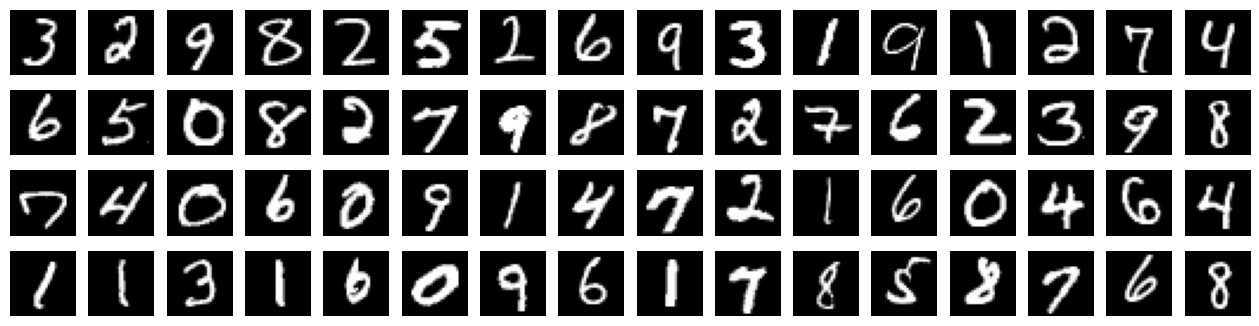

In [ ]:
# Import the required libraries
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

# Now you can use the path "/content/drive/My Drive/collabproject/" to access your files
# For example, to list files in that directory:
import os
os.listdir('/content/drive/My Drive/')


# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Download and load the training dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

# Extract a batch of unique images
unique_images, unique_labels = next(iter(train_loader))
unique_images = unique_images.numpy()

# Display a grid of unique images
fig, axes = plt.subplots(4, 16, figsize=(16, 4), sharex=True, sharey=True)  # Create a 4x16 grid of subplots with a wider figure

for i in range(4):  # Loop over rows
    for j in range(16):  # Loop over columns
        index = i * 16 + j  # Calculate the index in the batch
        axes[i, j].imshow(unique_images[index].squeeze(), cmap='gray')  # Show the image using a grayscale colormap
        axes[i, j].axis('off')  # Turn off axis labels and ticks

plt.show()  # Display the plot

Our dataset comprising 60,000 square images, showcasing hand-drawn digits ranging from 0 to 9. We’re going to construct the Stable Diffusion architecture and train our model using these images. We’ll experiment with various parameter values during the training process. Once the model is trained, we’ll give it a digit, like 5, and it will generate an image of a hand-drawn digit 5 for us.

## Setting the Stage

We’ll be working with a range of Python libraries throughout this project, so let’s import them:

Make sure to have these libraries installed to avoid any errors:

In [ ]:
%%capture

# Install the 'einops' library for easy manipulation of tensors
!pip install einops

# Install the 'lpips' library for computing perceptual similarity between images
!pip install lpips

In [ ]:
# Import the PyTorch library for tensor operations.
import torch

# Import the neural network module from PyTorch.
import torch.nn as nn

# Import functional operations from PyTorch.
import torch.nn.functional as F

# Import the 'numpy' library for numerical operations.
import numpy as np

# Import the 'functools' module for higher-order functions.
import functools

# Import the Adam optimizer from PyTorch.
from torch.optim import Adam

# Import the DataLoader class from PyTorch for handling datasets.
from torch.utils.data import DataLoader

# Import data transformation functions from torchvision.
import torchvision.transforms as transforms

# Import the MNIST dataset from torchvision.
from torchvision.datasets import MNIST

# Import 'tqdm' for creating progress bars during training.
import tqdm

# Import 'trange' and 'tqdm' specifically for notebook compatibility.
from tqdm.notebook import trange, tqdm

# Import the learning rate scheduler from PyTorch.
from torch.optim.lr_scheduler import MultiplicativeLR, LambdaLR

# Import the 'matplotlib.pyplot' library for plotting graphs.
import matplotlib.pyplot as plt

# Import the 'make_grid' function from torchvision.utils for visualizing image grids.
from torchvision.utils import make_grid

# Importing the `rearrange` function from the `einops` library
from einops import rearrange

# Importing the `math` module for mathematical operations
import math

## Creating basic forward diffusion

Let’s begin with forward diffusion. In basic terms, the diffusion equation is:

![Forward Diffusion Equation](https://cdn-images-1.medium.com/max/8976/1*UUsPUx1QVfT-w6m9rp70sw.png)

Here, σ(***t***)>0 is the **noise strength**, **Δ*t*** is the **step size**, and **r∼N(0,1)** is a **standard normal random variable**. Simply put, we keep adding normally-distributed noise to our sample. Usually, the noise strength ***σ*(*t*)** is chosen to increase with time (as *t* gets larger).

In [ ]:
# Forward diffusion for N steps in 1D.
def forward_diffusion_1D(x0, noise_strength_fn, t0, nsteps, dt):
    """
    Parameters:
    - x0: Initial sample value (scalar)
    - noise_strength_fn: Function of time, outputs scalar noise strength
    - t0: Initial time
    - nsteps: Number of diffusion steps
    - dt: Time step size

    Returns:
    - x: Trajectory of sample values over time
    - t: Corresponding time points for the trajectory
    """

    # Initialize the trajectory array
    x = np.zeros(nsteps + 1)

    # Set the initial sample value
    x[0] = x0

    # Generate time points for the trajectory
    t = t0 + np.arange(nsteps + 1) * dt

    # Perform Euler-Maruyama time steps for diffusion simulation
    for i in range(nsteps):

        # Get the noise strength at the current time
        noise_strength = noise_strength_fn(t[i])

        # Generate a random normal variable
        random_normal = np.random.randn()

        # Update the trajectory using Euler-Maruyama method
        x[i + 1] = x[i] + random_normal * noise_strength

    # Return the trajectory and corresponding time points
    return x, t

Setting the noise strength function to always equal 1.

In [ ]:
# Example noise strength function: always equal to 1
def noise_strength_constant(t):
    """
    Example noise strength function that returns a constant value (1).

    Parameters:
    - t: Time parameter (unused in this example)

    Returns:
    - Constant noise strength (1)
    """
    return 1

Now that we have defined our forward diffusion component, let’s check whether it is working correctly or not for different trials.

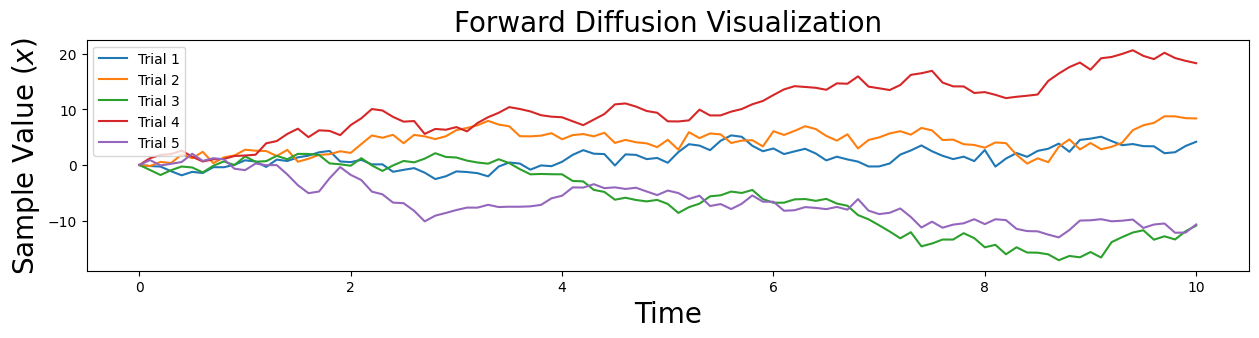

In [ ]:
# Number of diffusion steps
nsteps = 100

# Initial time
t0 = 0

# Time step size
dt = 0.1

# Noise strength function
noise_strength_fn = noise_strength_constant

# Initial sample value
x0 = 0

# Number of tries for visualization
num_tries = 5

# Setting larger width and smaller height for the plot
plt.figure(figsize=(15, 3))

# Loop for multiple trials
for i in range(num_tries):

    # Simulate forward diffusion
    x, t = forward_diffusion_1D(x0, noise_strength_fn, t0, nsteps, dt)

    # Plot the trajectory
    plt.plot(t, x, label=f'Trial {i+1}')  # Adding a label for each trial

# Labeling the plot
plt.xlabel('Time', fontsize=20)
plt.ylabel('Sample Value ($x$)', fontsize=20)

# Title of the plot
plt.title('Forward Diffusion Visualization', fontsize=20)

# Adding a legend to identify each trial
plt.legend()

# Show the plot
plt.show()


This visualization illustrates the forward diffusion process, which can be understood as slowly introducing noise to the starting sample. This leads to the creation of various samples as the diffusion process progresses, as depicted in the graph.

## Creating basic reverse diffusion

To undo this diffusion process, we use a similar update rule:

![Reverse Diffusion Equation](https://cdn-images-1.medium.com/max/17044/1*y7HnA0G91dn338gay1GKDA.png)

**s(x,t)** is known as the **score function**. Knowing this function allows us to reverse the forward diffusion and convert noise back into our initial state.

If our starting point is always just one point at ***x*0​=0**, and the noise strength is constant, then the score function is exactly equal to

![Score function when noise strength is constant](https://cdn-images-1.medium.com/max/9160/1*nLumpTF2q9gqdwV5SMRNqQ.png)

Now that we know the mathematical equations, let’s first code the 1D reverse diffusion function.


In [ ]:
# Reverse diffusion for N steps in 1D.
def reverse_diffusion_1D(x0, noise_strength_fn, score_fn, T, nsteps, dt):
    """
    Parameters:
    - x0: Initial sample value (scalar)
    - noise_strength_fn: Function of time, outputs scalar noise strength
    - score_fn: Score function
    - T: Final time
    - nsteps: Number of diffusion steps
    - dt: Time step size

    Returns:
    - x: Trajectory of sample values over time
    - t: Corresponding time points for the trajectory
    """

    # Initialize the trajectory array
    x = np.zeros(nsteps + 1)

    # Set the initial sample value
    x[0] = x0

    # Generate time points for the trajectory
    t = np.arange(nsteps + 1) * dt

    # Perform Euler-Maruyama time steps for reverse diffusion simulation
    for i in range(nsteps):

        # Calculate noise strength at the current time
        noise_strength = noise_strength_fn(T - t[i])

        # Calculate the score using the score function
        score = score_fn(x[i], 0, noise_strength, T - t[i])

        # Generate a random normal variable
        random_normal = np.random.randn()

        # Update the trajectory using the reverse Euler-Maruyama method
        x[i + 1] = x[i] + score * noise_strength**2 * dt + noise_strength * random_normal * np.sqrt(dt)

    # Return the trajectory and corresponding time points
    return x, t

Now, we will code a very simple score function, always equal to 1.

In [ ]:
# Example score function: always equal to 1
def score_simple(x, x0, noise_strength, t):
    """
    Parameters:
    - x: Current sample value (scalar)
    - x0: Initial sample value (scalar)
    - noise_strength: Scalar noise strength at the current time
    - t: Current time

    Returns:
    - score: Score calculated based on the provided formula
    """

    # Calculate the score using the provided formula
    score = - (x - x0) / ((noise_strength**2) * t)

    # Return the calculated score
    return score

Just as we plot our forward diffusion function to check whether it is working correctly, we will do the same for our reverse diffusion function.

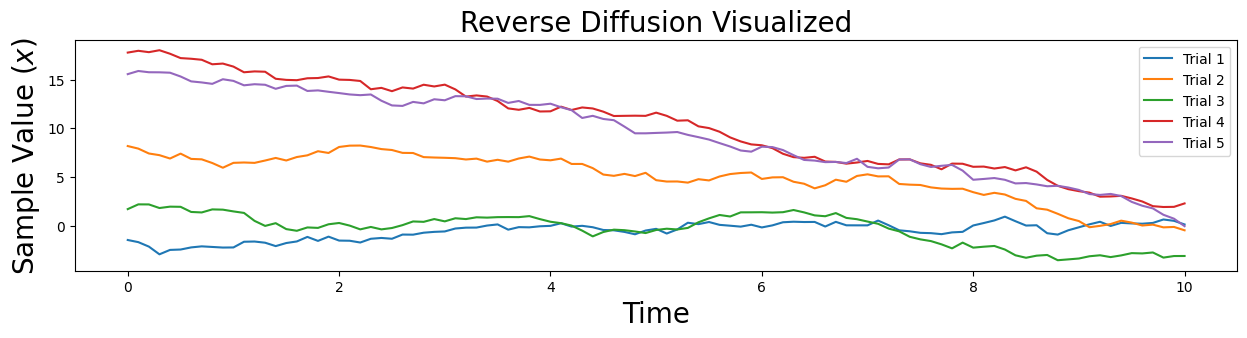

In [ ]:
# Number of reverse diffusion steps
nsteps = 100

# Initial time for reverse diffusion
t0 = 0

# Time step size for reverse diffusion
dt = 0.1

# Function defining constant noise strength for reverse diffusion
noise_strength_fn = noise_strength_constant

# Example score function for reverse diffusion
score_fn = score_simple

# Initial sample value for reverse diffusion
x0 = 0

# Final time for reverse diffusion
T = 11

# Number of tries for visualization
num_tries = 5

# Setting larger width and smaller height for the plot
plt.figure(figsize=(15, 3))

# Loop for multiple trials
for i in range(num_tries):
    # Draw from the noise distribution, which is diffusion for time T with noise strength 1
    x0 = np.random.normal(loc=0, scale=T)

    # Simulate reverse diffusion
    x, t = reverse_diffusion_1D(x0, noise_strength_fn, score_fn, T, nsteps, dt)

    # Plot the trajectory
    plt.plot(t, x, label=f'Trial {i+1}')  # Adding a label for each trial

# Labeling the plot
plt.xlabel('Time', fontsize=20)
plt.ylabel('Sample Value ($x$)', fontsize=20)

# Title of the plot
plt.title('Reverse Diffusion Visualized', fontsize=20)

# Adding a legend to identify each trial
plt.legend()

# Show the plot
plt.show()

This visualization shows that after the forward diffusion process creates a sample from the complex data distribution (as seen in the previous forward diffusion visualization), the reverse diffusion process maps it back to the simple distribution using a series of inverse transformations.

## Learning Score Function

In real-world scenarios, we start without knowledge of the score function, our goal is to learn it. One approach involves training a neural network to **‘denoise’** samples using the denoising objective:

![denoising objective equation](https://cdn-images-1.medium.com/max/16188/1*ISU3X_VXowq3pYCxNdCkeg.png)

Here, **p0​(x0​)** represents our **target distribution** (e.g., images of cars and cats), and **x(*noised)**​ denotes the sample from **the target distribution x0​** after a single forward diffusion step. In simpler terms, [ x(noised) ​− x0 ]​ is essentially a **normally-distributed** random variable.

Expressing the same idea in a way closer to the actual implementation:

![other way to write denoising objective equation](https://cdn-images-1.medium.com/max/16224/1*-qIF57sPHuf_vMs4MHLNww.png)

It’s important to understand the concept that our aim is to predict the amount of noise added to each part of our sample effectively at every time *t* in the diffusion process and for every *x*0​ in our original distribution (cars, cats, etc.)

In these expressions:

* *J* represents the denoising objective.

* E denotes the expectation.

* *t* represents the time parameter.

* *x*0​ is a sample from the target distribution *p*0​(*x*0​).

* *x(*noised)​ represents the target distribution sample *x*0​ after one forward diffusion step.

* *s*(⋅,⋅) represents the score function.

* *σ*(*t*) is a function of time.

* *ϵ* is a normally-distributed random variable.

So far, we’ve covered the basics of how forward and backward diffusion work, and we’ve explored how to learn our score function.

## Time Embedding for Neural Network

Learning the score function is like transforming random noise into something meaningful. To do this, we use a neural network to approximate the score function. When dealing with images, we want our neural network to cooperate well with them and the score function we aim to learn depends on time, we need a method to ensure our neural network accurately responds to time variations. To achieve this, we can use a time embedding.

Instead of only providing our network with a single time value, we represent the current time using many sinusoidal features. By offering various representations of time, we aim to enhance our network’s ability to adapt to time changes. This approach allows us to effectively learn a time-dependent score function *s*(*x*,*t*).

To enable our neural network to interact with time, we need to create two modules.

In [ ]:
# Define a module for Gaussian random features used to encode time steps.
class GaussianFourierProjection(nn.Module):
    def __init__(self, embed_dim, scale=30.):
        """
        Parameters:
        - embed_dim: Dimensionality of the embedding (output dimension)
        - scale: Scaling factor for random weights (frequencies)
        """
        super().__init__()

        # Randomly sample weights (frequencies) during initialization.
        # These weights (frequencies) are fixed during optimization and are not trainable.
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)

    def forward(self, x):
        """
        Parameters:
        - x: Input tensor representing time steps
        """
        # Calculate the cosine and sine projections: Cosine(2 pi freq x), Sine(2 pi freq x)
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi

        # Concatenate the sine and cosine projections along the last dimension
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

The GaussianFourierProjection function is designed to create a module for generating Gaussian random features, which will be used to represent time steps in our context. When we utilize this module, it generates random frequencies that remain fixed throughout the optimization process. Once we provide an input tensor x to the module, it computes sine and cosine projections by multiplying x with these pre-defined random frequencies. These projections are then concatenated to form a feature representation of the input, effectively capturing temporal patterns. This module is valuable in our task, where we aim to incorporate time-related information into our neural network.

In [ ]:
# Define a module for a fully connected layer that reshapes outputs to feature maps.
class Dense(nn.Module):
    def __init__(self, input_dim, output_dim):
        """
        Parameters:
        - input_dim: Dimensionality of the input features
        - output_dim: Dimensionality of the output features
        """
        super().__init__()

        # Define a fully connected layer
        self.dense = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        """
        Parameters:
        - x: Input tensor

        Returns:
        - Output tensor after passing through the fully connected layer
          and reshaping to a 4D tensor (feature map)
        """

        # Apply the fully connected layer and reshape the output to a 4D tensor
        return self.dense(x)[..., None, None]
        # This broadcasts the 2D tensor to a 4D tensor, adding the same value across space.

Dense is designed to reshape the output of the fully connected layer into a 4D tensor, effectively converting it into a feature map. The module takes as input the dimensionality of the input features (input_dim) and the desired dimensionality of the output features (output_dim). During the forward pass, the input tensor x is processed through the fully connected layer (self.dense(x)) and the output is reshaped into a 4D tensor by adding two singleton dimensions at the end ([..., None, None]). This reshaping operation effectively transforms the output into a feature map suitable for further processing in convolutional layers. This operation broadcasts the 2D tensor to a 4D tensor by adding the same value across spatial dimensions.

Now that we’ve established the two modules for integrating time interaction into our neural network, it’s time to proceed with coding the main neural network.

## Coding the U-Net Architecture with Concatenation

When dealing with images, our neural network needs to work seamlessly with them and capture the inherent features associated with images.

We opt for a [U-Net architecture](https://www.geeksforgeeks.org/u-net-architecture-explained/), which combines a CNN-like structure with downscaling/upscaling operations. This combination helps the network focus on image features at different spatial scales.

In [ ]:
# Define a time-dependent score-based model built upon the U-Net architecture.
class UNet(nn.Module):
    def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
        """
        Initialize a time-dependent score-based network.

        Parameters:
        - marginal_prob_std: A function that takes time t and gives the standard deviation
          of the perturbation kernel p_{0t}(x(t) | x(0)).
        - channels: The number of channels for feature maps of each resolution.
        - embed_dim: The dimensionality of Gaussian random feature embeddings.
        """

        super().__init__()

        # Gaussian random feature embedding layer for time
        self.time_embed = nn.Sequential(
            GaussianFourierProjection(embed_dim=embed_dim),
            nn.Linear(embed_dim, embed_dim)
        )

        # Encoding layers where the resolution decreases
        self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])

        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])

        # Additional encoding layers (copied from the original code)
        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])

        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])

        # Decoding layers where the resolution increases
        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])

        self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])

        self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])

        self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)

        # The swish activation function
        self.act = lambda x: x * torch.sigmoid(x)
        self.marginal_prob_std = marginal_prob_std

    def forward(self, x, t, y=None):
        """
        Parameters:
        - x: Input tensor
        - t: Time tensor
        - y: Target tensor (not used in this forward pass)

        Returns:
        - h: Output tensor after passing through the U-Net architecture
        """

        # Obtain the Gaussian random feature embedding for t
        embed = self.act(self.time_embed(t))

        # Encoding path
        h1 = self.conv1(x) + self.dense1(embed)
        h1 = self.act(self.gnorm1(h1))
        h2 = self.conv2(h1) + self.dense2(embed)
        h2 = self.act(self.gnorm2(h2))

        # Additional encoding path layers (copied from the original code)
        h3 = self.conv3(h2) + self.dense3(embed)
        h3 = self.act(self.gnorm3(h3))
        h4 = self.conv4(h3) + self.dense4(embed)
        h4 = self.act(self.gnorm4(h4))

        # Decoding path
        h = self.tconv4(h4)
        h += self.dense5(embed)
        h = self.act(self.tgnorm4(h))
        h = self.tconv3(torch.cat([h, h3], dim=1))
        h += self.dense6(embed)
        h = self.act(self.tgnorm3(h))
        h = self.tconv2(torch.cat([h, h2], dim=1))
        h += self.dense7(embed)
        h = self.act(self.tgnorm2(h))
        h = self.tconv1(torch.cat([h, h1], dim=1))

        # Normalize output
        h = h / self.marginal_prob_std(t)[:, None, None, None]
        return h

We created a model that understands how things change over time. It uses a special architecture called U-Net. Imagine you have a starting picture, and you want to see how it transforms over different moments in time. The model learns patterns and details from these transformations. The code defines how this learning happens, using various layers and computations. It makes sure the output, or the generated pictures, are properly adjusted based on the time information. It’s like a smart tool for understanding and predicting how things evolve visually.

Throughout the U-Net model’s architecture, the shape of tensors evolves as information passes through encoding and decoding paths. In the encoding path, which involves downsampling, tensors undergo shape reduction with each convolutional layer — h1, h2, h3, and h4 successively. In the decoding path, the transpose convolutional layers initiate the recovery of spatial information. The tensor h starts to restore the original spatial dimensions, and at each step (h4 to h1), features from earlier layers are added back to facilitate upsampling. Finally, the last layer, represented by h, produces the output, and a normalization step ensures appropriate scaling for the generated image. The specifics of tensor shapes depend on factors like filter sizes, strides, and padding used in the convolutional layers, shaping the model's ability to capture and reconstruct details effectively.

## Coding the U-Net Architecture with Addition

Diffusion models can work well with various architectural choices. In the previous model we built, we combined the tensor from the down blocks using concatenation for skip connection. In the upcoming model we’ll code, we’ll simply add the tensor from the down blocks for skip connection.

In [ ]:
# Define a time-dependent score-based model built upon the U-Net architecture.
class UNet_res(nn.Module):
    def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
        """
        Parameters:
        - marginal_prob_std: A function that takes time t and gives the standard deviation
          of the perturbation kernel p_{0t}(x(t) | x(0)).
        - channels: The number of channels for feature maps of each resolution.
        - embed_dim: The dimensionality of Gaussian random feature embeddings.
        """

        super().__init__()

        # Gaussian random feature embedding layer for time
        self.time_embed = nn.Sequential(
            GaussianFourierProjection(embed_dim=embed_dim),
            nn.Linear(embed_dim, embed_dim)
        )

        # Encoding layers where the resolution decreases
        self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])

        # Decoding layers where the resolution increases
        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
        self.tconv3 = nn.ConvTranspose2d(channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
        self.tconv2 = nn.ConvTranspose2d(channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
        self.tconv1 = nn.ConvTranspose2d(channels[0], 1, 3, stride=1)

        # The swish activation function
        self.act = lambda x: x * torch.sigmoid(x)
        self.marginal_prob_std = marginal_prob_std

    def forward(self, x, t, y=None):
        """
        Parameters:
        - x: Input tensor
        - t: Time tensor
        - y: Target tensor (not used in this forward pass)

        Returns:
        - h: Output tensor after passing through the U-Net architecture
        """

        # Obtain the Gaussian random feature embedding for t
        embed = self.act(self.time_embed(t))

        # Encoding path
        h1 = self.conv1(x) + self.dense1(embed)
        h1 = self.act(self.gnorm1(h1))
        h2 = self.conv2(h1) + self.dense2(embed)
        h2 = self.act(self.gnorm2(h2))
        h3 = self.conv3(h2) + self.dense3(embed)
        h3 = self.act(self.gnorm3(h3))
        h4 = self.conv4(h3) + self.dense4(embed)
        h4 = self.act(self.gnorm4(h4))

        # Decoding path
        h = self.tconv4(h4)
        h += self.dense5(embed)
        h = self.act(self.tgnorm4(h))
        h = self.tconv3(h + h3)
        h += self.dense6(embed)
        h = self.act(self.tgnorm3(h))
        h = self.tconv2(h + h2)
        h += self.dense7(embed)
        h = self.act(self.tgnorm2(h))
        h = self.tconv1(h + h1)

        # Normalize output
        h = h / self.marginal_prob_std(t)[:, None, None, None]
        return h

The UNet_res model that we have just coded is a variant of the standard UNet model. While both models follow the U-Net architecture, the key difference lies in how skip connections are implemented. In the original UNet model, skip connections concatenate tensors from the encoding path with tensors in the decoding path. However, in the UNet_res model, skip connections involve directly adding tensors from the encoding path to the corresponding tensors in the decoding path. This variation in skip connection strategies can influence the information flow and interactions between different resolution levels, potentially affecting the model’s capacity to capture features and dependencies in the data.

## Forward Diffusion Process with Exponential Noise

We will define the specific forward diffusion process:

![forward diffusion equation](https://cdn-images-1.medium.com/max/4800/1*Ou_YMRL_KT-FNoF8G9Ausg.png)

This formula represents a dynamic system where the variable *x* changes over time (*t*) with the introduction of noise (*dw*). The noise level is determined by the parameter *σ*, and it increases exponentially as time progresses.

Given this process and an initial value *x*(0), we can find an analytical solution for *x*(*t*):

![Analytical solution for the sample](https://cdn-images-1.medium.com/max/8940/1*qxi_K5tx1CIl7JSlLniaSg.png)

In this context, *σ*(*t*) is referred to as the marginal standard deviation. Essentially, it represents the variability of the distribution of *x*(*t*) given the initial value *x*(0).

For our specific case, the marginal standard deviation is calculated as:

![marginal standard deviation equation](https://cdn-images-1.medium.com/max/12416/1*09vg7fc0iLae3XsiI2nmTQ.png)

This formula provides a detailed understanding of how the noise level (*σ*) evolves over time, influencing the variability of the system.

In [ ]:
# Using GPU
device = "cuda"

# Marginal Probability Standard Deviation Function
def marginal_prob_std(t, sigma):
    """
    Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

    Parameters:
    - t: A vector of time steps.
    - sigma: The $\sigma$ in our SDE.

    Returns:
    - The standard deviation.
    """
    # Convert time steps to a PyTorch tensor
    t = torch.tensor(t, device=device)

    # Calculate and return the standard deviation based on the given formula
    return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

Now that we have coded the function for marginal probability standard deviation, we can similarly code the diffusion coefficient.

In [ ]:
# Using GPU
device = "cuda"

def diffusion_coeff(t, sigma):
    """
    Compute the diffusion coefficient of our SDE.

    Parameters:
    - t: A vector of time steps.
    - sigma: The $\sigma$ in our SDE.

    Returns:
    - The vector of diffusion coefficients.
    """
    # Calculate and return the diffusion coefficients based on the given formula
    return torch.tensor(sigma**t, device=device)


Now we initialize both marginal probability standard deviation and diffusion coefficient with sigma 25

In [ ]:
# Sigma Value
sigma =  25.0

# marginal probability standard
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)

# diffusion coefficient
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

After coding both modules, it’s time to develop the loss function for our stable diffusion architecture.

## Coding the Loss Function

Now, we’re putting together the U-Net we made earlier with a method to learn the score function. We’ll create a loss function and train the neural network.

In [ ]:
def loss_fn(model, x, marginal_prob_std, eps=1e-5):
    """
    The loss function for training score-based generative models.

    Parameters:
    - model: A PyTorch model instance that represents a time-dependent score-based model.
    - x: A mini-batch of training data.
    - marginal_prob_std: A function that gives the standard deviation of the perturbation kernel.
    - eps: A tolerance value for numerical stability.
    """
    # Sample time uniformly in the range (eps, 1-eps)
    random_t = torch.rand(x.shape[0], device=x.device) * (1. - 2 * eps) + eps
    # Find the noise std at the sampled time `t`
    std = marginal_prob_std(random_t)

    # Generate normally distributed noise
    z = torch.randn_like(x)

    # Perturb the input data with the generated noise
    perturbed_x = x + z * std[:, None, None, None]

    # Get the score from the model using the perturbed data and time
    score = model(perturbed_x, random_t)

    # Calculate the loss based on the score and noise
    loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1, 2, 3)))

    return loss

This loss function figures out how wrong our model is while training. It involves picking a random time, getting the noise level, adding this noise to our data, and then checking how off our model’s prediction is from reality. The aim is to reduce this error during training.

## Coding the Sampler

Stable Diffusion creates an image by starting with a totally random one. The noise predictor then guesses how noisy the image is, and this guessed noise is removed from the image. This whole cycle repeats several times, resulting in a clean image at the end.

This cleaning-up process is called “sampling” because Stable Diffusion produces a fresh image sample at each step. The way it creates these samples is called the **“sampler”** or **“sampling method”**.

Stable Diffusion has various options for creating image samples, and one method we’ll use is the Euler–Maruyama method, also known as the Euler method.


In [ ]:
# Number of steps
num_steps = 500

def Euler_Maruyama_sampler(score_model,
                            marginal_prob_std,
                            diffusion_coeff,
                            batch_size=64,
                            x_shape=(1, 28, 28),
                            num_steps=num_steps,
                            device='cuda',
                            eps=1e-3, y=None):
    """
    Generate samples from score-based models with the Euler-Maruyama solver.

    Parameters:
    - score_model: A PyTorch model that represents the time-dependent score-based model.
    - marginal_prob_std: A function that gives the standard deviation of the perturbation kernel.
    - diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    - batch_size: The number of samplers to generate by calling this function once.
    - x_shape: The shape of the samples.
    - num_steps: The number of sampling steps, equivalent to the number of discretized time steps.
    - device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    - eps: The smallest time step for numerical stability.
    - y: Target tensor (not used in this function).

    Returns:
    - Samples.
    """

    # Initialize time and the initial sample
    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, *x_shape, device=device) * marginal_prob_std(t)[:, None, None, None]

    # Generate time steps
    time_steps = torch.linspace(1., eps, num_steps, device=device)
    step_size = time_steps[0] - time_steps[1]
    x = init_x

    # Sample using Euler-Maruyama method
    with torch.no_grad():
        for time_step in tqdm(time_steps):
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            g = diffusion_coeff(batch_time_step)
            mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step, y=y) * step_size
            x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)

    # Do not include any noise in the last sampling step.
    return mean_x

In [ ]:
# Define the score-based model and move it to the specified device
score_model = torch.nn.DataParallel(UNet(marginal_prob_std=marginal_prob_std_fn))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

score_model = score_model.to(device)

# Number of training epochs
n_epochs = 50
# Size of a mini-batch
batch_size = 2048
# Learning rate
lr = 5e-4

# Load the MNIST dataset and create a data loader
dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# Define the Adam optimizer for training the model
optimizer = Adam(score_model.parameters(), lr=lr)

# Progress bar for epochs
tqdm_epoch = trange(n_epochs)
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    # Iterate through mini-batches in the data loader
    for x, y in tqdm(data_loader):
        x = x.to(device)
        # Calculate the loss and perform backpropagation
        loss = loss_fn(score_model, x, marginal_prob_std_fn)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
    # Print the averaged training loss for the current epoch
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    # Save the model checkpoint after each epoch of training
    ckpt1 = '/content/drive/My Drive/ckpt.pth'
    torch.save(score_model.state_dict(), ckpt1)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
<ipython-input-35-a1f1fa6cc02f>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Upon executing the training code, the entire training process is expected to complete in approximately 7 minutes for each epoch. The average loss observed across epochs is **41.481**, and the trained model will be saved in the current directory with the filename “**ckpt.pth”**.

Let’s visualize the results from our **U-Net architecture based on concatenation**. It’s important to note that we haven’t started working on developing a system where we pass a prompt to generate specific results. The current visualization is simply based on random inputs.

In [ ]:
# Load the pre-trained checkpoint from disk.
device = 'cuda'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Load the pre-trained model checkpoint
ckpt = torch.load('ckpt.pth', map_location=device)
score_model.load_state_dict(ckpt)

# Set sample batch size and number of steps
sample_batch_size = 64
num_steps = 500

# Choose the Euler-Maruyama sampler
sampler = Euler_Maruyama_sampler

# Generate samples using the specified sampler
samples = sampler(score_model,
                  marginal_prob_std_fn,
                  diffusion_coeff_fn,
                  sample_batch_size,
                  num_steps=num_steps,
                  device=device,
                  y=None)

# Clip samples to be in the range [0, 1]
samples = samples.clamp(0.0, 1.0)

# Visualize the generated samples
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

# Plot the sample grid
plt.figure(figsize=(6, 6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

The current results are not satisfactory, as it is challenging to identify any numbers clearly. However, there is still a lot to cover in this blog, which will showcase promising results.

## Training U-Net Addition Architecture

The U-Net architecture with concatenation did not perform well. However, let’s proceed with training the U-Net architecture based on addition and determine whether it yields improved results or not.

We will be using following hyperparameters: **75 epochs** for training, a **mini-batch size** of 1**024**, and a **learning rate** of 10**e-3**. The training will be conducted on the **MNIST** dataset.

In [ ]:
# Initialize the alternate U-Net model for training.
score_model = torch.nn.DataParallel(UNet_res(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)

# Set the number of training epochs, mini-batch size, and learning rate.
n_epochs = 75
batch_size = 1024
lr = 1e-3

# Load the MNIST dataset for training.
dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# Initialize the Adam optimizer with the specified learning rate.
optimizer = Adam(score_model.parameters(), lr=lr)
# Learning rate scheduler to adjust the learning rate during training.
scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: max(0.2, 0.98 ** epoch))

# Training loop over epochs.
tqdm_epoch = trange(n_epochs)
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    # Iterate over mini-batches in the training data loader.
    for x, y in data_loader:
        x = x.to(device)
        # Compute the loss for the current mini-batch.
        loss = loss_fn(score_model, x, marginal_prob_std_fn)
        # Zero the gradients, backpropagate, and update the model parameters.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Accumulate the total loss and the number of processed items.
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]

    # Adjust the learning rate using the scheduler.
    scheduler.step()
    lr_current = scheduler.get_last_lr()[0]

    # Print the average loss and learning rate for the current epoch.
    print('{} Average Loss: {:5f} lr {:.1e}'.format(epoch, avg_loss / num_items, lr_current))
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))

    # Save the model checkpoint after each epoch of training.
    ckpt2 = '/content/drive/My Drive/ckpt_res.pth'
    torch.save(score_model.state_dict(), ckpt2)


Upon executing the training code, the entire training process is expected to complete in approximately 11 minutes for each epoch. The trained model will be saved in the current directory with the filename “**ckpt_res.pth”**.

Let’s visualize the results from our **U-Net architecture based on addition**.

In [ ]:
# Load the pre-trained checkpoint from disk.
device = 'cuda'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the pre-trained model checkpoint
ckpt = torch.load('ckpt2', map_location=device)
score_model.load_state_dict(ckpt)

# Set sample batch size and number of steps
sample_batch_size = 64
num_steps = 500

# Choose the Euler-Maruyama sampler
sampler = Euler_Maruyama_sampler

# Generate samples using the specified sampler
samples = sampler(score_model,
                  marginal_prob_std_fn,
                  diffusion_coeff_fn,
                  sample_batch_size,
                  num_steps=num_steps,
                  device=device,
                  y=None)

# Clip samples to be in the range [0, 1]
samples = samples.clamp(0.0, 1.0)

# Visualize the generated samples
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

# Plot the sample grid
plt.figure(figsize=(6, 6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

## Building Attention Layers

When creating attention models, we usually have three main parts:

 1. **Cross Attention: **Handles self/cross attention for sequences.

 2. **Transformer Block:** Combines attention with a neural network for processing.

 3. **Spatial Transformer:** Transforms the spatial tensor in a U-net to a sequential form and vice versa.

Let’s break down the math behind attention models in simpler terms. In QKV (query-key-value) attention, we represent queries, keys, and values as vectors. These vectors help us connect words or images on one side of a translation task to the other side.

These vectors (q, k, v) are linearly related to the encoder’s hidden state vectors (e) and the decoder’s hidden state vectors (h):

![query, key and value](https://cdn-images-1.medium.com/max/11068/1*Oos1-uFVJRLahxne93d2nw.png)

​To decide what to ‘pay attention’ to, we calculate the inner product (similarity) of each key (k) and query (q). To ensure the values are reasonable, we normalize them by the length of the query vectors (qi).

The final attention distribution is obtained by applying softmax to these values:

![Applying Softmax ](https://cdn-images-1.medium.com/max/13436/1*CR9S6fqnXACKE_IbwETMaw.png)

This attention distribution helps pick out a relevant combination of features. For instance, when translating the phrase **“This is cool”** from English to French, the correct answer (**“c’est cool”**) involves paying attention to both words simultaneously, rather than translating each word separately. Mathematically, we use the attention distribution to weight the values (vj):

![attention distribution](https://cdn-images-1.medium.com/max/5600/1*yZTz2UuUhltTuZEM1LaPAA.png)

Now that we understand the basics of attention and the three attention modules we need to build, let’s begin coding them.​

Let’s start by coding the first attention layer, which is **CrossAttention**.

In [ ]:
class CrossAttention(nn.Module):
    def __init__(self, embed_dim, hidden_dim, context_dim=None, num_heads=1):
        """
        Initialize the CrossAttention module.

        Parameters:
        - embed_dim: The dimensionality of the output embeddings.
        - hidden_dim: The dimensionality of the hidden representations.
        - context_dim: The dimensionality of the context representations (if not self attention).
        - num_heads: Number of attention heads (currently supports 1 head).

        Note: For simplicity reasons, the implementation assumes 1-head attention.
        Feel free to implement multi-head attention using fancy tensor manipulations.
        """
        super(CrossAttention, self).__init__()

        self.hidden_dim = hidden_dim
        self.context_dim = context_dim
        self.embed_dim = embed_dim


        # Linear layer for query projection
        self.query = nn.Linear(hidden_dim, embed_dim, bias=False)

        # Check if self-attention or cross-attention
        if context_dim is None:
            self.self_attn = True
            self.key = nn.Linear(hidden_dim, embed_dim, bias=False)
            self.value = nn.Linear(hidden_dim, hidden_dim, bias=False)
        else:
            self.self_attn = False
            self.key = nn.Linear(context_dim, embed_dim, bias=False)
            self.value = nn.Linear(context_dim, hidden_dim, bias=False)

    def forward(self, tokens, context=None):
        """
        Forward pass of the CrossAttention module.

        Parameters:
        - tokens: Input tokens with shape [batch, sequence_len, hidden_dim].
        - context: Context information with shape [batch, context_seq_len, context_dim].
                    If self_attn is True, context is ignored.

        Returns:
        - ctx_vecs: Context vectors after attention with shape [batch, sequence_len, embed_dim].
        """

        if self.self_attn:
            # Self-attention case
            Q = self.query(tokens)
            K = self.key(tokens)
            V = self.value(tokens)
        else:
            # Cross-attention case
            Q = self.query(tokens)
            K = self.key(context)
            V = self.value(context)

        # Compute score matrices, attention matrices, and context vectors
        scoremats = torch.einsum("BTH,BSH->BTS", Q, K)  # Inner product of Q and K, a tensor
        attnmats = F.softmax(scoremats / math.sqrt(self.embed_dim), dim=-1)  # Softmax of scoremats
        ctx_vecs = torch.einsum("BTS,BSH->BTH", attnmats, V)  # Weighted average value vectors by attnmats

        return ctx_vecs

The CrossAttention class is a module designed for handling attention mechanisms in neural networks. It takes input tokens and, optionally, context information. If used for self-attention, it focuses on relationships within the input tokens. In the case of cross-attention, it considers the interaction between input tokens and context information. The module employs linear projections for query, key, and value transformations. It calculates score matrices, applies softmax for attention weights, and computes context vectors by combining the weighted values based on attention weights. This mechanism allows the network to selectively focus on different parts of the input or context, aiding in capturing relevant information during the learning process. The forward method implements these operations, returning context vectors after attention.

Let’s proceed to the second attention layer, known as **TransformerBlock**.

## Training U-Net Concatenation Architecture

We have developed two U-Net architectures: one utilizing addition and the other utilizing concatenation. To initiate training, we will use the U-Net architecture based on concatenation with the following hyperparameters: **50 epochs** for training, a **mini-batch size** of **2048**, and a **learning rate** of **5e-4**. The training will be conducted on the **MNIST** dataset.


In [ ]:
class TransformerBlock(nn.Module):
    """The transformer block that combines self-attn, cross-attn, and feed forward neural net"""
    def __init__(self, hidden_dim, context_dim):
        """
        Initialize the TransformerBlock.

        Parameters:
        - hidden_dim: The dimensionality of the hidden state.
        - context_dim: The dimensionality of the context tensor.

        Note: For simplicity, the self-attn and cross-attn use the same hidden_dim.
        """

        super(TransformerBlock, self).__init__()

        # Self-attention module
        self.attn_self = CrossAttention(hidden_dim, hidden_dim)

        # Cross-attention module
        self.attn_cross = CrossAttention(hidden_dim, hidden_dim, context_dim)

        # Layer normalization modules
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.norm3 = nn.LayerNorm(hidden_dim)

        # Implement a 2-layer MLP with K * hidden_dim hidden units, and nn.GELU nonlinearity
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, 3 * hidden_dim),
            nn.GELU(),
            nn.Linear(3 * hidden_dim, hidden_dim)
        )

    def forward(self, x, context=None):
        """
        Forward pass of the TransformerBlock.

        Parameters:
        - x: Input tensor with shape [batch, sequence_len, hidden_dim].
        - context: Context tensor with shape [batch, context_seq_len, context_dim].

        Returns:
        - x: Output tensor after passing through the TransformerBlock.
        """

        # Apply self-attention with layer normalization and residual connection
        x = self.attn_self(self.norm1(x)) + x

        # Apply cross-attention with layer normalization and residual connection
        x = self.attn_cross(self.norm2(x), context=context) + x

        # Apply feed forward neural network with layer normalization and residual connection
        x = self.ffn(self.norm3(x)) + x

        return x

The TransformerBlock class represents a building block in a transformer model, incorporating self-attention, cross-attention, and a feed-forward neural network. It takes input tensors with shape [batch, sequence_len, hidden_dim] and, optionally, a context tensor with shape [batch, context_seq_len, context_dim]. The self-attention and cross-attention modules are followed by layer normalization and a residual connection. Additionally, the block includes a two-layer MLP with a GELU nonlinearity for further non-linear transformations. The output is obtained after passing through the TransformerBlock.

Let’s proceed to the final attention layer, known as **SpatialTransformer**.

In [ ]:
class SpatialTransformer(nn.Module):
    def __init__(self, hidden_dim, context_dim):
        """
        Initialize the SpatialTransformer.

        Parameters:
        - hidden_dim: The dimensionality of the hidden state.
        - context_dim: The dimensionality of the context tensor.
        """
        super(SpatialTransformer, self).__init__()

        # TransformerBlock for spatial transformation
        self.transformer = TransformerBlock(hidden_dim, context_dim)

    def forward(self, x, context=None):
        """
        Forward pass of the SpatialTransformer.

        Parameters:
        - x: Input tensor with shape [batch, channels, height, width].
        - context: Context tensor with shape [batch, context_seq_len, context_dim].

        Returns:
        - x: Output tensor after applying spatial transformation.
        """
        b, c, h, w = x.shape
        x_in = x

        # Combine the spatial dimensions and move the channel dimension to the end
        x = rearrange(x, "b c h w -> b (h w) c")

        # Apply the sequence transformer
        x = self.transformer(x, context)

        # Reverse the process
        x = rearrange(x, 'b (h w) c -> b c h w', h=h, w=w)

        # Residue connection
        return x + x_in

Now, you can incorporate **SpatialTransformer** layers into our U-Net architecture.

## Coding the U-Net Architecture with Spatial Transformer

We’re going to code our U-Net architecture using the attention layers created in the previous step.

In [ ]:
class UNet_Tranformer(nn.Module):
    """A time-dependent score-based model built upon U-Net architecture."""

    def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256,
                  text_dim=256, nClass=10):
        """
        Initialize a time-dependent score-based network.

        Parameters:
        - marginal_prob_std: A function that takes time t and gives the standard deviation
          of the perturbation kernel p_{0t}(x(t) | x(0)).
        - channels: The number of channels for feature maps of each resolution.
        - embed_dim: The dimensionality of Gaussian random feature embeddings of time.
        - text_dim: The embedding dimension of text/digits.
        - nClass: Number of classes to model.
        """
        super().__init__()

        # Gaussian random feature embedding layer for time
        self.time_embed = nn.Sequential(
            GaussianFourierProjection(embed_dim=embed_dim),
            nn.Linear(embed_dim, embed_dim)
        )

        # Encoding layers where the resolution decreases
        self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])

        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])

        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
        self.attn3 = SpatialTransformer(channels[2], text_dim)

        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])
        self.attn4 = SpatialTransformer(channels[3], text_dim)

        # Decoding layers where the resolution increases
        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])

        self.tconv3 = nn.ConvTranspose2d(channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])

        self.tconv2 = nn.ConvTranspose2d(channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
        self.tconv1 = nn.ConvTranspose2d(channels[0], 1, 3, stride=1)

        # The swish activation function
        self.act = nn.SiLU()
        self.marginal_prob_std = marginal_prob_std
        self.cond_embed = nn.Embedding(nClass, text_dim)

    def forward(self, x, t, y=None):
        """
        Forward pass of the UNet_Transformer model.

        Parameters:
        - x: Input tensor.
        - t: Time tensor.
        - y: Target tensor.

        Returns:
        - h: Output tensor after passing through the UNet_Transformer architecture.
        """
        # Obtain the Gaussian random feature embedding for t
        embed = self.act(self.time_embed(t))
        y_embed = self.cond_embed(y).unsqueeze(1)

        # Encoding path
        h1 = self.conv1(x) + self.dense1(embed)
        h1 = self.act(self.gnorm1(h1))
        h2 = self.conv2(h1) + self.dense2(embed)
        h2 = self.act(self.gnorm2(h2))
        h3 = self.conv3(h2) + self.dense3(embed)
        h3 = self.act(self.gnorm3(h3))
        h3 = self.attn3(h3, y_embed)
        h4 = self.conv4(h3) + self.dense4(embed)
        h4 = self.act(self.gnorm4(h4))
        h4 = self.attn4(h4, y_embed)

        # Decoding path
        h = self.tconv4(h4) + self.dense5(embed)
        h = self.act(self.tgnorm4(h))
        h = self.tconv3(h + h3) + self.dense6(embed)
        h = self.act(self.tgnorm3(h))
        h = self.tconv2(h + h2) + self.dense7(embed)
        h = self.act(self.tgnorm2(h))
        h = self.tconv1(h + h1)

        # Normalize output
        h = h / self.marginal_prob_std(t)[:, None, None, None]
        return h



Now that we’ve implemented the U-Net architecture with attention layers, it’s time to update our loss function.

## Updating U-Net Loss with Denoising Condition

Let’s update the loss function by incorporating the y information during training.

In [ ]:
def loss_fn_cond(model, x, y, marginal_prob_std, eps=1e-5):
    """The loss function for training score-based generative models with conditional information.

    Parameters:
    - model: A PyTorch model instance that represents a time-dependent score-based model.
    - x: A mini-batch of training data.
    - y: Conditional information (target tensor).
    - marginal_prob_std: A function that gives the standard deviation of the perturbation kernel.
    - eps: A tolerance value for numerical stability.

    Returns:
    - loss: The calculated loss.
    """
    # Sample time uniformly in the range [eps, 1-eps]
    random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
    # Generate random noise with the same shape as the input
    z = torch.randn_like(x)
    # Compute the standard deviation of the perturbation kernel at the sampled time
    std = marginal_prob_std(random_t)
    # Perturb the input data with the generated noise and scaled by the standard deviation
    perturbed_x = x + z * std[:, None, None, None]
    # Get the model's score for the perturbed input, considering conditional information
    score = model(perturbed_x, random_t, y=y)
    # Calculate the loss using the score and perturbation
    loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1, 2, 3)))
    return loss

## Training U-Net Architecture With Attention Layers

The advantage of training the U-Net architecture based on the attention layer is that, once trained, we can provide a specific number for our stable diffusion model to draw. Let’s initiate the training process with the following hyperparameters: 100 epochs, a mini-batch size of 1024, and a learning rate of 10e-3. The training will be performed using the **MNIST** dataset.

In [ ]:
# Specify whether to continue training or initialize a new model

continue_training = False # Either True or False

if not continue_training:

    # Initialize a new UNet with Transformer model
    score_model = torch.nn.DataParallel(UNet_Tranformer(marginal_prob_std=marginal_prob_std_fn))
    score_model = score_model.to(device)

# Set training hyperparameters
n_epochs =   100   #{'type':'integer'}
batch_size =  1024 #{'type':'integer'}
lr = 10e-4         #{'type':'number'}

# Load the MNIST dataset and create a data loader
dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# Define the optimizer and learning rate scheduler
optimizer = Adam(score_model.parameters(), lr=lr)
scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: max(0.2, 0.98 ** epoch))

# Use tqdm to display a progress bar over epochs
tqdm_epoch = trange(n_epochs)
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0

    # Iterate over batches in the data loader
    for x, y in tqdm(data_loader):
        x = x.to(device)

        # Compute the loss using the conditional score-based model
        loss = loss_fn_cond(score_model, x, y, marginal_prob_std_fn)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]

    # Adjust learning rate using the scheduler
    scheduler.step()
    lr_current = scheduler.get_last_lr()[0]

    # Print epoch information including average loss and current learning rate
    print('{} Average Loss: {:5f} lr {:.1e}'.format(epoch, avg_loss / num_items, lr_current))
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))

    # Save the model checkpoint after each epoch of training
    ckpt3 = '/content/drive/My Drive/path_to_your_file/ckpt.pth'
    torch.save(score_model.state_dict(), ckpt3)

Upon executing the training code, the entire training process is expected to complete in approximately 20 minutes. The trained model will be saved in the current directory with the filename “**ckpt_transformer.pth”**.

## Generating Images

Now, with the addition of conditional generation through attention layers, we can instruct our stable diffusion model to draw any digit. Let’s observe its outcome when tasked to draw the digit 9.


In [ ]:
## Load the pre-trained checkpoint from disk.
# device = 'cuda' ['cuda', 'cpu'] {'type':'string'}
ckpt = torch.load('/content/drive/My Drive/path_to_your_file/ckpt.pth', map_location=device)
score_model.load_state_dict(ckpt)


########### Specify the digit for which to generate samples
###########
digit = 9
###########
###########



# Set the batch size for generating samples
sample_batch_size = 64
# Set the number of steps for the Euler-Maruyama sampler
num_steps = 250
# Choose the sampler type (Euler-Maruyama, pc_sampler, ode_sampler)
sampler = Euler_Maruyama_sampler # ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}
# score_model.eval()

## Generate samples using the specified sampler.
samples = sampler(score_model,
        marginal_prob_std_fn,
        diffusion_coeff_fn,
        sample_batch_size,
        num_steps=num_steps,
        device=device,
        y=digit*torch.ones(sample_batch_size, dtype=torch.long))

## Sample visualization.
samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
# Create a grid of samples for visualization
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

# Plot the generated samples
plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

## Comments Task 2.5
A GAN is two networks working "against" each other, and slowly improving.

A Stable Diffusion works iteratevly and removes parts of the input, to build of a scence of the essence of the token.